In [ ]:
# ============================================================================
# CELL 1: WHISPER-ONLY SETUP WITH BALANCED DATASET
# ============================================================================
print("="*80)
print("🎯 PURE WHISPER MODEL + BALANCED DATASET")
print("Target: F1 Score >= 0.75 | Balanced Classes")
print("="*80)

# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

# Install required packages for Whisper-only
print("\n[Installing Whisper-only packages...]")
!pip install transformers==4.40.0 -q
!pip install torch torchaudio -q
!pip install scikit-learn pandas numpy -q
!pip install librosa soundfile -q
!pip install imbalanced-learn -q
!pip install matplotlib seaborn -q
!pip install datasets -q
print("✅ Whisper-only installation complete!")

print("\n🔄 Restarting runtime for clean setup...")
import os
os.kill(os.getpid(), 9)

🎯 PURE WHISPER MODEL + BALANCED DATASET
Target: F1 Score >= 0.75 | Balanced Classes
Mounted at /content/drive

[Installing Whisper-only packages...]


In [1]:
# ============================================================================
# CELL 2: WHISPER-ONLY IMPORTS
# ============================================================================
import os
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
import torch
import librosa
import soundfile as sf
from scipy.stats import skew, kurtosis

# WHISPER-ONLY: Remove HuBERT imports
from transformers import WhisperModel, WhisperFeatureExtractor, WhisperProcessor

from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.decomposition import PCA
from sklearn.svm import SVC
from sklearn.metrics import (
    accuracy_score, f1_score, precision_score, recall_score,
    confusion_matrix, classification_report, cohen_kappa_score
)

# Enhanced balancing techniques
from imblearn.over_sampling import SMOTE, ADASYN, BorderlineSMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.combine import SMOTETomek, SMOTEENN

import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
from tqdm.auto import tqdm
import joblib
import json

# Mount Drive again after restart
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"✅ Using device: {device}")

# Set random seeds for reproducibility
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(RANDOM_SEED)

print("✅ Whisper-only imports successful!")

Mounted at /content/drive
✅ Using device: cuda
✅ Whisper-only imports successful!


In [2]:
# ============================================================================
# CELL 3: WHISPER-ONLY CONFIGURATION WITH BALANCING
# ============================================================================
class WhisperOnlyConfig:
    """Pure Whisper Configuration with Dataset Balancing"""

    # ========================================================================
    # PATHS (Keep same as before)
    # ========================================================================
    BASE_PATH = '/content/drive/MyDrive/task_1'
    TRAINING_PATH = os.path.join(BASE_PATH, 'training')
    EXCEL_PATH = os.path.join(BASE_PATH, 'sand_task_1.xlsx')
    OUTPUT_PATH = os.path.join(BASE_PATH, 'whisper_only_balanced_v1')

    # Sheet names
    SHEET_TRAINING = 'Training Baseline - Task 1'
    SHEET_VALIDATION = 'Validation Baseline - Task 1'

    # Audio types
    AUDIO_TYPES = ['phomationA', 'phomationE', 'phomationI', 'phomationO', 'phomationU',
                   'rhythmKA', 'rhythmPA', 'rhythmTA']

    # ========================================================================
    # PURE WHISPER CONFIGURATION (REMOVED HUBERT)
    # ========================================================================
    WHISPER_MODEL = 'openai/whisper-base'
    SAMPLING_RATE = 16000
    MAX_AUDIO_LENGTH = 16000 * 15  # 15 seconds

    # Enhanced Whisper feature extraction
    USE_MULTI_LAYER = True
    WHISPER_LAYERS_TO_USE = [-4, -3, -2, -1]  # Last 4 encoder layers
    USE_MULTI_POOLING = True
    WHISPER_POOLING_STRATEGIES = ['mean', 'std', 'max', 'min']

    # Use both encoder and decoder features
    USE_ENCODER_FEATURES = True
    USE_DECODER_FEATURES = True
    DECODER_INPUT_IDS = None  # Will use default prompt

    # Statistical features (optional - can disable for pure Whisper)
    USE_STATISTICAL_FEATURES = False  # Set to False for pure Whisper features

    # ========================================================================
    # ADVANCED DATASET BALANCING CONFIGURATION
    # ========================================================================
    BALANCING_STRATEGY = 'SMOTEENN'  # Options: 'SMOTE', 'ADASYN', 'SMOTEENN', 'SMOTETomek'

    # SMOTE Configuration
    SMOTE_STRATEGY = 'auto'  # 'auto' balances all classes to majority
    SMOTE_K_NEIGHBORS = 3

    # Under-sampling configuration
    UNDER_SAMPLER_STRATEGY = 'auto'

    # Target class distribution (force balanced)
    TARGET_MIN_SAMPLES = 80  # Minimum samples per class after balancing

    # ========================================================================
    # PREPROCESSING
    # ========================================================================
    USE_ROBUST_SCALING = True
    USE_PCA = True
    PCA_VARIANCE = 0.95

    # Audio preprocessing
    AUDIO_TRIM_DB = 20
    AUDIO_NORMALIZE = True
    MIN_AUDIO_LENGTH_SEC = 2

    # ========================================================================
    # OPTIMIZED SVM FOR BALANCED DATA
    # ========================================================================
    SVM_CONFIG = {
        'kernel': 'rbf',
        'C': 100.0,  # Reduced for balanced data
        'gamma': 'scale',
        'class_weight': None,  # Set to None since we're balancing the dataset
        'probability': True,
        'decision_function_shape': 'ovr',
        'max_iter': 10000,
        'cache_size': 2000,
        'tol': 1e-4
    }

    # Cross-validation
    N_FOLDS = 5
    RANDOM_SEED = 42

    # Class names
    CLASS_NAMES = {
        0: 'Severe Dysarthria',
        1: 'Moderate Dysarthria',
        2: 'Mild Dysarthria',
        3: 'No Dysarthria (ALS)',
        4: 'Healthy'
    }

config = WhisperOnlyConfig()
os.makedirs(config.OUTPUT_PATH, exist_ok=True)

print("\n" + "="*80)
print("🎯 PURE WHISPER-ONLY CONFIGURATION WITH BALANCING")
print("="*80)
print(f"Base Path: {config.BASE_PATH}")
print(f"Whisper Model: {config.WHISPER_MODEL}")
print(f"Balancing Strategy: {config.BALANCING_STRATEGY}")
print(f"Multi-Layer Extraction: {config.USE_MULTI_LAYER}")
print(f"Multi-Pooling: {config.USE_MULTI_POOLING}")
print(f"Statistical Features: {config.USE_STATISTICAL_FEATURES}")
print(f"Target Min Samples: {config.TARGET_MIN_SAMPLES}")
print("="*80)

# Verify paths
print(f"\n🔍 Verifying paths...")
assert os.path.exists(config.BASE_PATH), f"Base path not found: {config.BASE_PATH}"
assert os.path.exists(config.TRAINING_PATH), f"Training path not found: {config.TRAINING_PATH}"
assert os.path.exists(config.EXCEL_PATH), f"Excel file not found: {config.EXCEL_PATH}"
print("✅ All paths verified!")


🎯 PURE WHISPER-ONLY CONFIGURATION WITH BALANCING
Base Path: /content/drive/MyDrive/task_1
Whisper Model: openai/whisper-base
Balancing Strategy: SMOTEENN
Multi-Layer Extraction: True
Multi-Pooling: True
Statistical Features: False
Target Min Samples: 80

🔍 Verifying paths...
✅ All paths verified!


In [3]:
# ============================================================================
# CELL 4: LOAD PURE WHISPER MODEL (REMOVED HUBERT)
# ============================================================================
print("\n" + "="*80)
print("[2/9] LOADING PURE WHISPER MODEL")
print("="*80)
print(f"Model: {config.WHISPER_MODEL}")
print("⏱ Loading Whisper model...")

try:
    # Load Whisper components
    whisper_feature_extractor = WhisperFeatureExtractor.from_pretrained(config.WHISPER_MODEL)
    whisper_processor = WhisperProcessor.from_pretrained(config.WHISPER_MODEL)
    whisper_model = WhisperModel.from_pretrained(config.WHISPER_MODEL)

    # Move to device and set to evaluation mode
    whisper_model = whisper_model.to(device)
    whisper_model.eval()

    print(f"\n✅ Whisper loaded successfully!")
    print(f"  Model size: {sum(p.numel() for p in whisper_model.parameters()) / 1e6:.1f}M parameters")
    print(f"  Hidden size: {whisper_model.config.d_model}")
    print(f"  Encoder layers: {whisper_model.config.encoder_layers}")
    print(f"  Decoder layers: {whisper_model.config.decoder_layers}")
    print(f"  Feature extractor SR: {whisper_feature_extractor.sampling_rate} Hz")

    # Create default decoder input IDs for feature extraction
    config.DECODER_INPUT_IDS = torch.tensor([[1] * 448]).to(device)  # Default prompt

except Exception as e:
    print(f"❌ Error loading Whisper: {e}")
    raise

print("\n🎯 Model ready for pure Whisper feature extraction!")


[2/9] LOADING PURE WHISPER MODEL
Model: openai/whisper-base
⏱ Loading Whisper model...


Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.



✅ Whisper loaded successfully!
  Model size: 72.6M parameters
  Hidden size: 512
  Encoder layers: 6
  Decoder layers: 6
  Feature extractor SR: 16000 Hz

🎯 Model ready for pure Whisper feature extraction!


In [4]:
# ============================================================================
# CELL 5: PURE WHISPER FEATURE EXTRACTION (NO HUBERT)
# ============================================================================
print("\n" + "="*80)
print("[3/9] PURE WHISPER FEATURE EXTRACTION")
print("="*80)

def load_audio_enhanced(audio_path, target_sr=16000, max_length=None):
    """Enhanced audio loading with preprocessing"""
    try:
        # Load audio
        audio, sr = librosa.load(audio_path, sr=target_sr, mono=True)

        # Advanced trimming
        audio, _ = librosa.effects.trim(audio, top_db=config.AUDIO_TRIM_DB)

        # Normalize amplitude
        if config.AUDIO_NORMALIZE:
            audio = librosa.util.normalize(audio)

        # Handle length constraints
        if max_length and len(audio) > max_length:
            audio = audio[:max_length]

        # Ensure minimum length
        min_length = target_sr * config.MIN_AUDIO_LENGTH_SEC
        if len(audio) < min_length:
            audio = np.pad(audio, (0, min_length - len(audio)), mode='constant')

        return audio, sr

    except Exception as e:
        print(f"⚠ Error loading {audio_path}: {str(e)}")
        # Return silence as fallback
        return np.zeros(target_sr * config.MIN_AUDIO_LENGTH_SEC), target_sr

def extract_whisper_features(audio, sampling_rate=16000):
    """
    PURE WHISPER feature extraction with multi-layer and multi-pooling
    """
    try:
        # Preprocess audio for Whisper
        inputs = whisper_feature_extractor(
            audio,
            sampling_rate=sampling_rate,
            return_tensors="pt",
            padding=True
        )

        # Move to device
        inputs = {k: v.to(device) for k, v in inputs.items()}

        all_features = []

        # Extract encoder features
        if config.USE_ENCODER_FEATURES:
            with torch.no_grad():
                encoder_outputs = whisper_model.encoder(**inputs, output_hidden_states=True)

            # Extract from multiple encoder layers
            if config.USE_MULTI_LAYER:
                layers_to_process = config.WHISPER_LAYERS_TO_USE
            else:
                layers_to_process = [-1]

            for layer_idx in layers_to_process:
                hidden_state = encoder_outputs.hidden_states[layer_idx]  # [batch, time, hidden]

                # Apply multiple pooling strategies
                if config.USE_MULTI_POOLING:
                    pooling_methods = config.WHISPER_POOLING_STRATEGIES
                else:
                    pooling_methods = ['mean']

                for pool_strategy in pooling_methods:
                    if pool_strategy == 'mean':
                        pooled = hidden_state.mean(dim=1)
                    elif pool_strategy == 'max':
                        pooled = hidden_state.max(dim=1)[0]
                    elif pool_strategy == 'std':
                        pooled = hidden_state.std(dim=1)
                    elif pool_strategy == 'min':
                        pooled = hidden_state.min(dim=1)[0]

                    all_features.append(pooled.cpu().numpy().flatten())

        # Extract decoder features (optional)
        if config.USE_DECODER_FEATURES:
            with torch.no_grad():
                decoder_outputs = whisper_model.decoder(
                    input_ids=config.DECODER_INPUT_IDS,
                    encoder_hidden_states=encoder_outputs.last_hidden_state,
                    output_hidden_states=True
                )

            # Use last decoder layer
            decoder_hidden = decoder_outputs.hidden_states[-1]  # [batch, seq_len, hidden]

            # Pool decoder features
            decoder_pooled = decoder_hidden.mean(dim=1)  # Mean pooling
            all_features.append(decoder_pooled.cpu().numpy().flatten())

        # Concatenate all features
        features = np.concatenate(all_features, axis=0)

        return features

    except Exception as e:
        print(f"❌ Error in Whisper feature extraction: {e}")
        # Return zero features as fallback
        return np.zeros(512 * len(config.WHISPER_LAYERS_TO_USE) * len(config.WHISPER_POOLING_STRATEGIES))

def extract_features_for_subject(audio_files):
    """
    Extract features from all audio files for one subject
    Returns averaged feature vector
    """
    all_features = []

    for audio_file in audio_files:
        if os.path.exists(audio_file):
            # Load and preprocess audio
            audio, sr = load_audio_enhanced(audio_file, config.SAMPLING_RATE)

            # Extract Whisper features
            features = extract_whisper_features(audio, sr)
            all_features.append(features)
        else:
            print(f"⚠ Missing audio file: {audio_file}")

    if all_features:
        # Average features across all audio types for this subject
        return np.mean(all_features, axis=0)
    else:
        print(f"❌ No features extracted for subject")
        return None

print("✅ Pure Whisper feature extraction functions defined!")


[3/9] PURE WHISPER FEATURE EXTRACTION
✅ Pure Whisper feature extraction functions defined!


In [5]:
# ============================================================================
# CELL 6: ADVANCED DATASET BALANCING FUNCTIONS
# ============================================================================
print("\n" + "="*80)
print("[4/9] DATASET BALANCING CONFIGURATION")
print("="*80)

def analyze_class_balance(y):
    """Analyze and display class distribution"""
    unique, counts = np.unique(y, return_counts=True)
    print("📊 Current Class Distribution:")
    for cls, count in zip(unique, counts):
        pct = (count / len(y)) * 100
        print(f"  Class {cls} ({config.CLASS_NAMES[cls]:25s}): {count:3d} ({pct:5.2f}%)")

    imbalance_ratio = max(counts) / min(counts) if min(counts) > 0 else float('inf')
    print(f"  Imbalance Ratio: {imbalance_ratio:.2f}:1")

    return unique, counts

def apply_balancing_strategy(X, y, strategy='SMOTEENN'):
    """
    Apply advanced balancing strategy to dataset
    """
    print(f"\n🔄 Applying {strategy} balancing...")

    unique_before, counts_before = analyze_class_balance(y)

    if strategy == 'SMOTE':
        balancer = SMOTE(
            sampling_strategy=config.SMOTE_STRATEGY,
            k_neighbors=min(config.SMOTE_K_NEIGHBORS, min(counts_before) - 1),
            random_state=config.RANDOM_SEED
        )
    elif strategy == 'ADASYN':
        balancer = ADASYN(
            sampling_strategy=config.SMOTE_STRATEGY,
            n_neighbors=min(config.SMOTE_K_NEIGHBORS, min(counts_before) - 1),
            random_state=config.RANDOM_SEED
        )
    elif strategy == 'BorderlineSMOTE':
        balancer = BorderlineSMOTE(
            sampling_strategy=config.SMOTE_STRATEGY,
            k_neighbors=min(config.SMOTE_K_NEIGHBORS, min(counts_before) - 1),
            random_state=config.RANDOM_SEED
        )
    elif strategy == 'SMOTEENN':
        balancer = SMOTEENN(
            sampling_strategy=config.SMOTE_STRATEGY,
            random_state=config.RANDOM_SEED
        )
    elif strategy == 'SMOTETomek':
        balancer = SMOTETomek(
            sampling_strategy=config.SMOTE_STRATEGY,
            random_state=config.RANDOM_SEED
        )
    elif strategy == 'UnderSampling':
        balancer = RandomUnderSampler(
            sampling_strategy=config.UNDER_SAMPLER_STRATEGY,
            random_state=config.RANDOM_SEED
        )
    else:
        print(f"⚠ Unknown strategy {strategy}, using SMOTE")
        balancer = SMOTE(random_state=config.RANDOM_SEED)

    try:
        X_balanced, y_balanced = balancer.fit_resample(X, y)

        print(f"✅ Balancing completed!")
        print(f"  Before: {X.shape[0]} samples")
        print(f"  After:  {X_balanced.shape[0]} samples")

        unique_after, counts_after = analyze_class_balance(y_balanced)

        return X_balanced, y_balanced

    except Exception as e:
        print(f"❌ Error in balancing: {e}")
        print("⚠ Returning original data")
        return X, y

def force_min_samples(X, y, min_samples=80):
    """
    Force minimum number of samples per class through oversampling
    """
    print(f"\n🎯 Enforcing minimum {min_samples} samples per class...")

    unique, counts = np.unique(y, return_counts=True)
    X_resampled = [X]
    y_resampled = [y]

    for cls, count in zip(unique, counts):
        if count < min_samples:
            # Find indices for this class
            cls_indices = np.where(y == cls)[0]
            needed = min_samples - count

            # Random oversampling for this class
            oversampled_indices = np.random.choice(
                cls_indices,
                size=needed,
                replace=True
            )

            X_resampled.append(X[oversampled_indices])
            y_resampled.append(y[oversampled_indices])

            print(f"  Class {cls}: {count} -> {count + needed} samples")

    if len(X_resampled) > 1:
        X_forced = np.vstack(X_resampled)
        y_forced = np.hstack(y_resampled)

        print(f"✅ Forced balancing completed!")
        print(f"  Total samples: {X_forced.shape[0]}")
        analyze_class_balance(y_forced)

        return X_forced, y_forced
    else:
        print("✅ No forced balancing needed")
        return X, y

print("✅ Dataset balancing functions ready!")


[4/9] DATASET BALANCING CONFIGURATION
✅ Dataset balancing functions ready!


In [5]:
# ============================================================================
# CELL 7: COMPLETE RESTART - IMPORTS AND CONFIG
# ============================================================================
print("\n" + "="*80)
print("[4/9] COMPLETE RESTART - IMPORTS, CONFIG AND DATA LOADING")
print("="*80)

# First, import everything needed
import os
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
import torch
import librosa
import soundfile as sf
from scipy.stats import skew, kurtosis

# WHISPER-ONLY: Remove HuBERT imports
from transformers import WhisperModel, WhisperFeatureExtractor, WhisperProcessor

from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.decomposition import PCA
from sklearn.svm import SVC
from sklearn.metrics import (
    accuracy_score, f1_score, precision_score, recall_score,
    confusion_matrix, classification_report, cohen_kappa_score
)

# Enhanced balancing techniques
from imblearn.over_sampling import SMOTE, ADASYN, BorderlineSMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.combine import SMOTETomek, SMOTEENN

import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
from tqdm.auto import tqdm
import joblib
import json

# Mount Drive again after restart
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"✅ Using device: {device}")

# Set random seeds for reproducibility
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(RANDOM_SEED)

print("✅ All imports successful!")

# ============================================================================
# REDEFINE CONFIG CLASS
# ============================================================================
class WhisperOnlyConfig:
    """Pure Whisper Configuration with Dataset Balancing"""

    # ========================================================================
    # PATHS
    # ========================================================================
    BASE_PATH = '/content/drive/MyDrive/task_1'
    TRAINING_PATH = os.path.join(BASE_PATH, 'training')
    EXCEL_PATH = os.path.join(BASE_PATH, 'sand_task_1.xlsx')
    OUTPUT_PATH = os.path.join(BASE_PATH, 'whisper_only_balanced_v1')

    # Sheet names
    SHEET_TRAINING = 'Training Baseline - Task 1'
    SHEET_VALIDATION = 'Validation Baseline - Task 1'

    # Audio types
    AUDIO_TYPES = ['phomationA', 'phomationE', 'phomationI', 'phomationO', 'phomationU',
                   'rhythmKA', 'rhythmPA', 'rhythmTA']

    # ========================================================================
    # PURE WHISPER CONFIGURATION
    # ========================================================================
    WHISPER_MODEL = 'openai/whisper-base'
    SAMPLING_RATE = 16000
    MAX_AUDIO_LENGTH = 16000 * 15  # 15 seconds

    # Enhanced Whisper feature extraction
    USE_MULTI_LAYER = True
    WHISPER_LAYERS_TO_USE = [-4, -3, -2, -1]  # Last 4 encoder layers
    USE_MULTI_POOLING = True
    WHISPER_POOLING_STRATEGIES = ['mean', 'std', 'max', 'min']

    # Use both encoder and decoder features
    USE_ENCODER_FEATURES = True
    USE_DECODER_FEATURES = True
    DECODER_INPUT_IDS = None  # Will use default prompt

    # Statistical features (optional - can disable for pure Whisper)
    USE_STATISTICAL_FEATURES = False  # Set to False for pure Whisper features

    # ========================================================================
    # ADVANCED DATASET BALANCING CONFIGURATION
    # ========================================================================
    BALANCING_STRATEGY = 'SMOTEENN'  # Options: 'SMOTE', 'ADASYN', 'SMOTEENN', 'SMOTETomek'

    # SMOTE Configuration
    SMOTE_STRATEGY = 'auto'  # 'auto' balances all classes to majority
    SMOTE_K_NEIGHBORS = 3

    # Under-sampling configuration
    UNDER_SAMPLER_STRATEGY = 'auto'

    # Target class distribution (force balanced)
    TARGET_MIN_SAMPLES = 80  # Minimum samples per class after balancing

    # ========================================================================
    # PREPROCESSING
    # ========================================================================
    USE_ROBUST_SCALING = True
    USE_PCA = True
    PCA_VARIANCE = 0.95

    # Audio preprocessing
    AUDIO_TRIM_DB = 20
    AUDIO_NORMALIZE = True
    MIN_AUDIO_LENGTH_SEC = 2

    # ========================================================================
    # OPTIMIZED SVM FOR BALANCED DATA
    # ========================================================================
    SVM_CONFIG = {
        'kernel': 'rbf',
        'C': 100.0,  # Reduced for balanced data
        'gamma': 'scale',
        'class_weight': None,  # Set to None since we're balancing the dataset
        'probability': True,
        'decision_function_shape': 'ovr',
        'max_iter': 10000,
        'cache_size': 2000,
        'tol': 1e-4
    }

    # Cross-validation
    N_FOLDS = 5
    RANDOM_SEED = 42

    # Class names
    CLASS_NAMES = {
        0: 'Severe Dysarthria',
        1: 'Moderate Dysarthria',
        2: 'Mild Dysarthria',
        3: 'No Dysarthria (ALS)',
        4: 'Healthy'
    }

config = WhisperOnlyConfig()
os.makedirs(config.OUTPUT_PATH, exist_ok=True)

print("✅ Config defined successfully!")

# ============================================================================
# DEFINE BALANCING FUNCTIONS
# ============================================================================
def analyze_class_balance(y):
    """Analyze and display class distribution"""
    unique, counts = np.unique(y, return_counts=True)
    print("📊 Current Class Distribution:")
    for cls, count in zip(unique, counts):
        pct = (count / len(y)) * 100
        print(f"  Class {cls} ({config.CLASS_NAMES[cls]:25s}): {count:3d} ({pct:5.2f}%)")

    imbalance_ratio = max(counts) / min(counts) if min(counts) > 0 else float('inf')
    print(f"  Imbalance Ratio: {imbalance_ratio:.2f}:1")

    return unique, counts

def apply_balancing_strategy(X, y, strategy='SMOTEENN'):
    """
    Apply advanced balancing strategy to dataset
    """
    print(f"\n🔄 Applying {strategy} balancing...")

    unique_before, counts_before = analyze_class_balance(y)

    if strategy == 'SMOTE':
        balancer = SMOTE(
            sampling_strategy=config.SMOTE_STRATEGY,
            k_neighbors=min(config.SMOTE_K_NEIGHBORS, min(counts_before) - 1),
            random_state=config.RANDOM_SEED
        )
    elif strategy == 'ADASYN':
        balancer = ADASYN(
            sampling_strategy=config.SMOTE_STRATEGY,
            n_neighbors=min(config.SMOTE_K_NEIGHBORS, min(counts_before) - 1),
            random_state=config.RANDOM_SEED
        )
    elif strategy == 'BorderlineSMOTE':
        balancer = BorderlineSMOTE(
            sampling_strategy=config.SMOTE_STRATEGY,
            k_neighbors=min(config.SMOTE_K_NEIGHBORS, min(counts_before) - 1),
            random_state=config.RANDOM_SEED
        )
    elif strategy == 'SMOTEENN':
        balancer = SMOTEENN(
            sampling_strategy=config.SMOTE_STRATEGY,
            random_state=config.RANDOM_SEED
        )
    elif strategy == 'SMOTETomek':
        balancer = SMOTETomek(
            sampling_strategy=config.SMOTE_STRATEGY,
            random_state=config.RANDOM_SEED
        )
    elif strategy == 'UnderSampling':
        balancer = RandomUnderSampler(
            sampling_strategy=config.UNDER_SAMPLER_STRATEGY,
            random_state=config.RANDOM_SEED
        )
    else:
        print(f"⚠ Unknown strategy {strategy}, using SMOTE")
        balancer = SMOTE(random_state=config.RANDOM_SEED)

    try:
        X_balanced, y_balanced = balancer.fit_resample(X, y)

        print(f"✅ Balancing completed!")
        print(f"  Before: {X.shape[0]} samples")
        print(f"  After:  {X_balanced.shape[0]} samples")

        unique_after, counts_after = analyze_class_balance(y_balanced)

        return X_balanced, y_balanced

    except Exception as e:
        print(f"❌ Error in balancing: {e}")
        print("⚠ Returning original data")
        return X, y

def force_min_samples(X, y, min_samples=80):
    """
    Force minimum number of samples per class through oversampling
    """
    print(f"\n🎯 Enforcing minimum {min_samples} samples per class...")

    unique, counts = np.unique(y, return_counts=True)
    X_resampled = [X]
    y_resampled = [y]

    for cls, count in zip(unique, counts):
        if count < min_samples:
            # Find indices for this class
            cls_indices = np.where(y == cls)[0]
            needed = min_samples - count

            # Random oversampling for this class
            oversampled_indices = np.random.choice(
                cls_indices,
                size=needed,
                replace=True
            )

            X_resampled.append(X[oversampled_indices])
            y_resampled.append(y[oversampled_indices])

            print(f"  Class {cls}: {count} -> {count + needed} samples")

    if len(X_resampled) > 1:
        X_forced = np.vstack(X_resampled)
        y_forced = np.hstack(y_resampled)

        print(f"✅ Forced balancing completed!")
        print(f"  Total samples: {X_forced.shape[0]}")
        analyze_class_balance(y_forced)

        return X_forced, y_forced
    else:
        print("✅ No forced balancing needed")
        return X, y

print("✅ Balancing functions defined!")

# ============================================================================
# LOAD DATA
# ============================================================================
def load_and_preprocess_data():
    """Load and preprocess training and validation data"""

    print("📊 Loading Excel data...")

    try:
        # Load training data
        train_df = pd.read_excel(config.EXCEL_PATH, sheet_name=config.SHEET_TRAINING)
        print(f"✅ Training data loaded: {len(train_df)} samples")

        # Load validation data
        val_df = pd.read_excel(config.EXCEL_PATH, sheet_name=config.SHEET_VALIDATION)
        print(f"✅ Validation data loaded: {len(val_df)} samples")

        # Basic data cleaning
        train_df = train_df.dropna(subset=['ID', 'Class'])
        val_df = val_df.dropna(subset=['ID', 'Class'])

        # Convert Class to integer (0-4) - adjust based on your actual class labels
        train_df['Class'] = train_df['Class'].astype(int)
        val_df['Class'] = val_df['Class'].astype(int)

        # Map classes to 0-4 range if they are currently 1-5
        if train_df['Class'].min() == 1:
            train_df['Class'] = train_df['Class'] - 1
            val_df['Class'] = val_df['Class'] - 1

        print(f"\n📈 Class distribution in Training data:")
        class_counts_train = train_df['Class'].value_counts().sort_index()
        for cls, count in class_counts_train.items():
            print(f"  Class {cls} ({config.CLASS_NAMES[cls]:25s}): {count:3d} samples")

        print(f"\n📈 Class distribution in Validation data:")
        class_counts_val = val_df['Class'].value_counts().sort_index()
        for cls, count in class_counts_val.items():
            print(f"  Class {cls} ({config.CLASS_NAMES[cls]:25s}): {count:3d} samples")

        return train_df, val_df

    except Exception as e:
        print(f"❌ Error loading data: {e}")
        raise

# Load the data
train_df, val_df = load_and_preprocess_data()

print(f"\n🎯 Target: Balance all classes to at least {config.TARGET_MIN_SAMPLES} samples")
print("✅ Data loading complete!")


[4/9] COMPLETE RESTART - IMPORTS, CONFIG AND DATA LOADING
Mounted at /content/drive
✅ Using device: cpu
✅ All imports successful!
✅ Config defined successfully!
✅ Balancing functions defined!
📊 Loading Excel data...
✅ Training data loaded: 219 samples
✅ Validation data loaded: 53 samples

📈 Class distribution in Training data:
  Class 0 (Severe Dysarthria        ):   4 samples
  Class 1 (Moderate Dysarthria      ):  22 samples
  Class 2 (Mild Dysarthria          ):  45 samples
  Class 3 (No Dysarthria (ALS)      ):  62 samples
  Class 4 (Healthy                  ):  86 samples

📈 Class distribution in Validation data:
  Class 0 (Severe Dysarthria        ):   2 samples
  Class 1 (Moderate Dysarthria      ):   4 samples
  Class 2 (Mild Dysarthria          ):  12 samples
  Class 3 (No Dysarthria (ALS)      ):  14 samples
  Class 4 (Healthy                  ):  21 samples

🎯 Target: Balance all classes to at least 80 samples
✅ Data loading complete!


In [19]:
# ============================================================================
# CELL 8: CORRECTED DATASET STRUCTURE ANALYSIS (FIXED)
# ============================================================================
print("\n" + "="*80)
print("[5/9] CORRECTED DATASET STRUCTURE ANALYSIS")
print("="*80)

def analyze_corrected_structure():
    print("🔍 Analyzing corrected dataset structure...")

    # Your dataset has audio files organized by type, not by subject
    audio_type_folders = config.AUDIO_TYPES
    print(f"📁 Audio type folders: {audio_type_folders}")

    # Count files in each folder
    file_counts = {}
    subject_ids_from_files = set()
    available_audio_types = []

    for audio_type in audio_type_folders:
        type_path = os.path.join(config.TRAINING_PATH, audio_type)
        if os.path.exists(type_path):
            files = os.listdir(type_path)
            wav_files = [f for f in files if f.endswith('.wav')]
            file_counts[audio_type] = len(wav_files)
            available_audio_types.append(audio_type)

            # Extract subject IDs from filenames
            for file in wav_files:
                # Extract ID from filename like "ID051_phonationA.wav"
                id_part = file.split('_')[0].replace('ID', '')
                if id_part.isdigit():
                    subject_ids_from_files.add(int(id_part))

            print(f"   ✅ {audio_type}: {len(wav_files)} files")
        else:
            print(f"   ❌ {audio_type}: Folder not found")

    print(f"\n📊 Unique subject IDs found in filenames: {len(subject_ids_from_files)}")
    print(f"   Sample IDs: {sorted(list(subject_ids_from_files))[:10]}...")
    print(f"\n✅ Available audio types: {available_audio_types}")

    # Update config with available types
    config.AVAILABLE_AUDIO_TYPES = available_audio_types

    return file_counts, subject_ids_from_files

file_counts, subject_ids = analyze_corrected_structure()


[5/9] CORRECTED DATASET STRUCTURE ANALYSIS
🔍 Analyzing corrected dataset structure...
📁 Audio type folders: ['phomationA', 'phomationE', 'phomationI', 'phomationO', 'phomationU', 'rhythmKA', 'rhythmPA', 'rhythmTA']
   ❌ phomationA: Folder not found
   ❌ phomationE: Folder not found
   ❌ phomationI: Folder not found
   ❌ phomationO: Folder not found
   ❌ phomationU: Folder not found
   ✅ rhythmKA: 272 files
   ✅ rhythmPA: 272 files
   ✅ rhythmTA: 272 files

📊 Unique subject IDs found in filenames: 272
   Sample IDs: [0, 1, 2, 3, 5, 6, 7, 8, 9, 10]...

✅ Available audio types: ['rhythmKA', 'rhythmPA', 'rhythmTA']


In [20]:
# ============================================================================
# CELL 9: FEATURE EXTRACTION WITH PROPER PADDING (FIXED)
# ============================================================================
print("\n" + "="*80)
print("[6/9] EXTRACTING FEATURES FROM AUDIO FILES")
print("="*80)

def get_audio_path_for_subject(subject_id, audio_type):
    """
    Construct audio file path for a subject and audio type
    Format: training/rhythmKA/IDXXX_rhythmKA.wav
    """
    # Pad ID with zeros (e.g., 51 -> ID051)
    id_str = f"ID{subject_id:03d}"
    filename = f"{id_str}_{audio_type}.wav"
    audio_path = os.path.join(config.TRAINING_PATH, audio_type, filename)
    return audio_path

def extract_whisper_features_fixed(audio, sampling_rate=16000):
    """
    FIXED: Whisper feature extraction with proper padding for mel spectrogram
    """
    try:
        # Ensure audio is the right length for Whisper
        # Whisper expects 30-second chunks (480,000 samples at 16kHz)
        target_length = 480000

        if len(audio) > target_length:
            audio = audio[:target_length]
        elif len(audio) < target_length:
            # Pad with zeros to reach target length
            audio = np.pad(audio, (0, target_length - len(audio)), mode='constant')

        # Preprocess audio for Whisper - this handles mel spectrogram creation
        inputs = whisper_feature_extractor(
            audio,
            sampling_rate=sampling_rate,
            return_tensors="pt",
            padding=True
        )

        # Move to device
        inputs = {k: v.to(device) for k, v in inputs.items()}

        all_features = []

        # Extract encoder features
        if config.USE_ENCODER_FEATURES:
            with torch.no_grad():
                encoder_outputs = whisper_model.encoder(**inputs, output_hidden_states=True)

            # Extract from multiple encoder layers
            if config.USE_MULTI_LAYER:
                layers_to_process = config.WHISPER_LAYERS_TO_USE
            else:
                layers_to_process = [-1]

            for layer_idx in layers_to_process:
                hidden_state = encoder_outputs.hidden_states[layer_idx]  # [batch, time, hidden]

                # Apply multiple pooling strategies
                if config.USE_MULTI_POOLING:
                    pooling_methods = config.WHISPER_POOLING_STRATEGIES
                else:
                    pooling_methods = ['mean']

                for pool_strategy in pooling_methods:
                    if pool_strategy == 'mean':
                        pooled = hidden_state.mean(dim=1)
                    elif pool_strategy == 'max':
                        pooled = hidden_state.max(dim=1)[0]
                    elif pool_strategy == 'std':
                        pooled = hidden_state.std(dim=1)
                    elif pool_strategy == 'min':
                        pooled = hidden_state.min(dim=1)[0]

                    all_features.append(pooled.cpu().numpy().flatten())

        # Extract decoder features (optional)
        if config.USE_DECODER_FEATURES:
            with torch.no_grad():
                decoder_outputs = whisper_model.decoder(
                    input_ids=config.DECODER_INPUT_IDS,
                    encoder_hidden_states=encoder_outputs.last_hidden_state,
                    output_hidden_states=True
                )

            # Use last decoder layer
            decoder_hidden = decoder_outputs.hidden_states[-1]  # [batch, seq_len, hidden]

            # Pool decoder features
            decoder_pooled = decoder_hidden.mean(dim=1)  # Mean pooling
            all_features.append(decoder_pooled.cpu().numpy().flatten())

        # Concatenate all features
        features = np.concatenate(all_features, axis=0)

        return features

    except Exception as e:
        print(f"❌ Error in Whisper feature extraction: {e}")
        import traceback
        traceback.print_exc()
        # Return zero features as fallback
        expected_size = 512 * len(config.WHISPER_LAYERS_TO_USE) * len(config.WHISPER_POOLING_STRATEGIES)
        if config.USE_DECODER_FEATURES:
            expected_size += 512
        return np.zeros(expected_size)

def extract_features_for_subject_fixed(subject_id):
    """
    Extract features from all available audio files for one subject
    Returns averaged feature vector
    """
    all_features = []
    successful_extractions = 0

    # Use only available audio types
    audio_types_to_use = config.AVAILABLE_AUDIO_TYPES

    for audio_type in audio_types_to_use:
        audio_path = get_audio_path_for_subject(subject_id, audio_type)

        if os.path.exists(audio_path):
            try:
                # Load and preprocess audio
                audio, sr = load_audio_enhanced(audio_path, config.SAMPLING_RATE)

                # Extract Whisper features with fixed padding
                features = extract_whisper_features_fixed(audio, sr)
                all_features.append(features)
                successful_extractions += 1

            except Exception as e:
                print(f"⚠️ Error processing {audio_path}: {e}")
        else:
            print(f"⚠️ Missing: {audio_path}")

    if all_features:
        # Average features across all audio types for this subject
        avg_features = np.mean(all_features, axis=0)
        return avg_features, successful_extractions
    else:
        print(f"❌ No features extracted for subject {subject_id}")
        return None, 0

print("✅ Fixed feature extraction functions ready!")
print("🔧 Key fixes:")
print("   - Proper audio padding to 30 seconds (480,000 samples)")
print("   - Handles mel spectrogram size requirements")
print("   - Uses only available audio types")


[6/9] EXTRACTING FEATURES FROM AUDIO FILES
✅ Fixed feature extraction functions ready!
🔧 Key fixes:
   - Proper audio padding to 30 seconds (480,000 samples)
   - Handles mel spectrogram size requirements
   - Uses only available audio types


In [23]:
# ============================================================================
# CELL 10: DIAGNOSE AND FIX FEATURE EXTRACTION
# ============================================================================
print("\n" + "="*80)
print("[7/9] DIAGNOSING AND FIXING FEATURE EXTRACTION")
print("="*80)

import librosa
import numpy as np
import torch

def test_audio_loading(subject_id=1):
    """Test audio loading for a single subject"""
    print(f"\n🔧 Testing audio loading for subject {subject_id}...")

    # Test with available audio types
    audio_types_to_use = config.AVAILABLE_AUDIO_TYPES

    for audio_type in audio_types_to_use:
        audio_path = get_audio_path_for_subject(subject_id, audio_type)
        print(f"  Checking: {audio_path}")

        if os.path.exists(audio_path):
            try:
                # Test basic audio loading
                audio, sr = librosa.load(audio_path, sr=config.SAMPLING_RATE)
                print(f"    ✅ Loaded: {len(audio)} samples, SR: {sr}")

                # Test enhanced loading
                audio_enhanced, sr_enhanced = load_audio_enhanced(audio_path, config.SAMPLING_RATE)
                print(f"    ✅ Enhanced: {len(audio_enhanced)} samples")

                return True, audio_enhanced, sr_enhanced

            except Exception as e:
                print(f"    ❌ Error loading {audio_type}: {e}")
                return False, None, None
        else:
            print(f"    ❌ File not found: {audio_path}")

    return False, None, None

def test_whisper_feature_extraction(audio, sr):
    """Test Whisper feature extraction"""
    print(f"\n🔧 Testing Whisper feature extraction...")

    try:
        # Test the fixed feature extraction
        features = extract_whisper_features_fixed(audio, sr)
        print(f"    ✅ Feature extraction successful!")
        print(f"    📊 Feature shape: {features.shape}")
        print(f"    📊 Feature range: [{features.min():.4f}, {features.max():.4f}]")
        print(f"    📊 Non-zero features: {np.count_nonzero(features)}/{len(features)}")

        return True, features

    except Exception as e:
        print(f"    ❌ Feature extraction failed: {e}")
        import traceback
        traceback.print_exc()
        return False, None

# Run diagnostics
success, test_audio, test_sr = test_audio_loading(subject_id=1)

if success:
    feature_success, test_features = test_whisper_feature_extraction(test_audio, test_sr)

    if feature_success:
        print(f"\n🎉 All tests passed! Ready for full feature extraction.")
    else:
        print(f"\n❌ Feature extraction needs fixing.")
else:
    print(f"\n❌ Audio loading failed. Check file paths and formats.")


[7/9] DIAGNOSING AND FIXING FEATURE EXTRACTION

🔧 Testing audio loading for subject 1...
  Checking: /content/drive/MyDrive/task_1/training/rhythmKA/ID001_rhythmKA.wav
    ✅ Loaded: 138880 samples, SR: 16000
    ✅ Enhanced: 120832 samples

🔧 Testing Whisper feature extraction...
    ✅ Feature extraction successful!
    📊 Feature shape: (8704,)
    📊 Feature range: [-509.6261, 98.0805]
    📊 Non-zero features: 8704/8704

🎉 All tests passed! Ready for full feature extraction.


In [26]:
# ============================================================================
# CELL 11: FIXED FEATURE EXTRACTION (HANDLES STRING IDs)
# ============================================================================
print("\n" + "="*80)
print("[8/9] FIXED FEATURE EXTRACTION")
print("="*80)

def extract_numeric_id(subject_id):
    """Extract numeric ID from string like 'ID000' or '000'"""
    if isinstance(subject_id, str):
        # Remove 'ID' prefix if present
        if subject_id.startswith('ID'):
            return int(subject_id[2:])
        else:
            return int(subject_id)
    else:
        return subject_id

def get_audio_path_for_subject_fixed(subject_id, audio_type):
    """
    Construct audio file path - handles both string and integer IDs
    """
    # Extract numeric ID
    numeric_id = extract_numeric_id(subject_id)

    # Pad ID with zeros (e.g., 1 -> ID001)
    id_str = f"ID{numeric_id:03d}"
    filename = f"{id_str}_{audio_type}.wav"
    audio_path = os.path.join(config.TRAINING_PATH, audio_type, filename)
    return audio_path

def extract_features_fixed(subject_id):
    """Fixed feature extraction that handles string IDs"""

    all_features = []
    successful_types = []

    for audio_type in config.AVAILABLE_AUDIO_TYPES:
        audio_path = get_audio_path_for_subject_fixed(subject_id, audio_type)

        if not os.path.exists(audio_path):
            print(f"    ⚠️ Missing: {os.path.basename(audio_path)}")
            continue

        try:
            print(f"    🔍 Processing: {audio_type}")

            # Load audio
            audio, sr = librosa.load(audio_path, sr=config.SAMPLING_RATE)

            # Simple preprocessing
            audio, _ = librosa.effects.trim(audio, top_db=20)
            audio = librosa.util.normalize(audio)

            # Ensure minimum length
            if len(audio) < 16000:  # 1 second minimum
                audio = np.pad(audio, (0, 16000 - len(audio)), mode='constant')

            # Extract features
            features = extract_whisper_features_fixed(audio, sr)

            if features is not None and len(features) > 0 and not np.all(features == 0):
                all_features.append(features)
                successful_types.append(audio_type)
                print(f"    ✅ {audio_type}: Success")
            else:
                print(f"    ⚠️ {audio_type}: Invalid features")

        except Exception as e:
            print(f"    ❌ {audio_type}: Error - {str(e)[:100]}...")
            continue

    if all_features:
        avg_features = np.mean(all_features, axis=0)
        print(f"    ✅ Subject {subject_id}: {len(successful_types)}/3 audio types successful")
        return avg_features
    else:
        print(f"    ❌ Subject {subject_id}: No features extracted")
        return None

# Extract features for training subjects
print("📊 Extracting features for training subjects...")
X_train_features = []
y_train_labels = []
failed_subjects = []

for idx, row in train_df.iterrows():
    subject_id = row['ID']
    label = row['Class']

    print(f"\n🔹 Processing subject {subject_id} (Class {label})...")
    features = extract_features_fixed(subject_id)

    if features is not None:
        X_train_features.append(features)
        y_train_labels.append(label)
    else:
        failed_subjects.append(subject_id)

X_train = np.array(X_train_features)
y_train = np.array(y_train_labels)

print(f"\n✅ Training features extracted: {X_train.shape[0]} subjects")
print(f"   Failed subjects: {len(failed_subjects)}")
print(f"   Feature shape: {X_train.shape}")

# Extract features for validation subjects
print("\n📊 Extracting features for validation subjects...")
X_val_features = []
y_val_labels = []

for idx, row in val_df.iterrows():
    subject_id = row['ID']
    label = row['Class']

    print(f"\n🔹 Processing subject {subject_id} (Class {label})...")
    features = extract_features_fixed(subject_id)

    if features is not None:
        X_val_features.append(features)
        y_val_labels.append(label)

X_val = np.array(X_val_features)
y_val = np.array(y_val_labels)

print(f"✅ Validation features extracted: {X_val.shape[0]} subjects")

# Save features
os.makedirs(config.OUTPUT_PATH, exist_ok=True)
np.save(os.path.join(config.OUTPUT_PATH, 'X_train.npy'), X_train)
np.save(os.path.join(config.OUTPUT_PATH, 'y_train.npy'), y_train)
np.save(os.path.join(config.OUTPUT_PATH, 'X_val.npy'), X_val)
np.save(os.path.join(config.OUTPUT_PATH, 'y_val.npy'), y_val)

print(f"\n💾 Features saved to: {config.OUTPUT_PATH}")


[8/9] FIXED FEATURE EXTRACTION
📊 Extracting features for training subjects...

🔹 Processing subject ID000 (Class 4)...
    🔍 Processing: rhythmKA
    ✅ rhythmKA: Success
    🔍 Processing: rhythmPA
    ✅ rhythmPA: Success
    🔍 Processing: rhythmTA
    ✅ rhythmTA: Success
    ✅ Subject ID000: 3/3 audio types successful

🔹 Processing subject ID001 (Class 4)...
    🔍 Processing: rhythmKA
    ✅ rhythmKA: Success
    🔍 Processing: rhythmPA
    ✅ rhythmPA: Success
    🔍 Processing: rhythmTA
    ✅ rhythmTA: Success
    ✅ Subject ID001: 3/3 audio types successful

🔹 Processing subject ID002 (Class 3)...
    🔍 Processing: rhythmKA
    ✅ rhythmKA: Success
    🔍 Processing: rhythmPA
    ✅ rhythmPA: Success
    🔍 Processing: rhythmTA
    ✅ rhythmTA: Success
    ✅ Subject ID002: 3/3 audio types successful

🔹 Processing subject ID003 (Class 2)...
    🔍 Processing: rhythmKA
    ✅ rhythmKA: Success
    🔍 Processing: rhythmPA
    ✅ rhythmPA: Success
    🔍 Processing: rhythmTA
    ✅ rhythmTA: Success
 

In [27]:
# ============================================================================
# QUICK DATA CHECK
# ============================================================================
print("🔍 Checking data structure...")
print(f"First few rows of training data:")
print(train_df[['ID', 'Class']].head(10))

print(f"\nData types:")
print(f"ID column type: {train_df['ID'].dtype}")
print(f"Sample IDs: {train_df['ID'].iloc[:5].tolist()}")

🔍 Checking data structure...
First few rows of training data:
      ID  Class
0  ID000      4
1  ID001      4
2  ID002      3
3  ID003      2
4  ID005      4
5  ID006      4
6  ID008      4
7  ID009      2
8  ID010      3
9  ID013      4

Data types:
ID column type: object
Sample IDs: ['ID000', 'ID001', 'ID002', 'ID003', 'ID005']


In [30]:
# ============================================================================
# CELL 12: LOAD FEATURES AND APPLY BALANCING (FINAL STEP)
# ============================================================================
print("\n" + "="*80)
print("[9/9] DATASET BALANCING - FINAL STEP")
print("="*80)

# Load the extracted features
X_train = np.load(os.path.join(config.OUTPUT_PATH, 'X_train.npy'))
y_train = np.load(os.path.join(config.OUTPUT_PATH, 'y_train.npy'))
X_val = np.load(os.path.join(config.OUTPUT_PATH, 'X_val.npy'))
y_val = np.load(os.path.join(config.OUTPUT_PATH, 'y_val.npy'))

print("📊 Loaded feature shapes:")
print(f"X_train: {X_train.shape}, y_train: {y_train.shape}")
print(f"X_val: {X_val.shape}, y_val: {y_val.shape}")

print("\n📈 Original class distribution:")
analyze_class_balance(y_train)

# Apply advanced balancing
print(f"\n🔄 Applying {config.BALANCING_STRATEGY} balancing...")
X_train_balanced, y_train_balanced = apply_balancing_strategy(
    X_train, y_train, strategy=config.BALANCING_STRATEGY
)

# Force minimum samples
X_train_final, y_train_final = force_min_samples(
    X_train_balanced, y_train_balanced, min_samples=config.TARGET_MIN_SAMPLES
)

print(f"\n✅ FINAL BALANCED DATASET:")
print(f"   Training samples: {X_train_final.shape[0]}")
print(f"   Feature dimension: {X_train_final.shape[1]}")
print(f"   Validation samples: {X_val.shape[0]}")

# Save the balanced dataset
np.save(os.path.join(config.OUTPUT_PATH, 'X_train_balanced.npy'), X_train_final)
np.save(os.path.join(config.OUTPUT_PATH, 'y_train_balanced.npy'), y_train_final)
np.save(os.path.join(config.OUTPUT_PATH, 'X_val.npy'), X_val)
np.save(os.path.join(config.OUTPUT_PATH, 'y_val.npy'), y_val)

print(f"\n💾 Balanced dataset saved:")
print(f"   X_train_balanced.npy: {X_train_final.shape}")
print(f"   y_train_balanced.npy: {y_train_final.shape}")
print(f"   X_val.npy: {X_val.shape}")
print(f"   y_val.npy: {y_val.shape}")


[9/9] DATASET BALANCING - FINAL STEP
📊 Loaded feature shapes:
X_train: (219, 8704), y_train: (219,)
X_val: (53, 8704), y_val: (53,)

📈 Original class distribution:
📊 Current Class Distribution:
  Class 0 (Severe Dysarthria        ):   4 ( 1.83%)
  Class 1 (Moderate Dysarthria      ):  22 (10.05%)
  Class 2 (Mild Dysarthria          ):  45 (20.55%)
  Class 3 (No Dysarthria (ALS)      ):  62 (28.31%)
  Class 4 (Healthy                  ):  86 (39.27%)
  Imbalance Ratio: 21.50:1

🔄 Applying SMOTEENN balancing...

🔄 Applying SMOTEENN balancing...
📊 Current Class Distribution:
  Class 0 (Severe Dysarthria        ):   4 ( 1.83%)
  Class 1 (Moderate Dysarthria      ):  22 (10.05%)
  Class 2 (Mild Dysarthria          ):  45 (20.55%)
  Class 3 (No Dysarthria (ALS)      ):  62 (28.31%)
  Class 4 (Healthy                  ):  86 (39.27%)
  Imbalance Ratio: 21.50:1
❌ Error in balancing: Expected n_neighbors <= n_samples_fit, but n_neighbors = 6, n_samples_fit = 4, n_samples = 4
⚠ Returning origin


[10/9] FEATURE ANALYSIS AND SUMMARY
📊 FEATURE STATISTICS:
Feature dimension: 8704
Mean features per dimension: [0.2315154  0.22046614 0.487284   0.15324439 0.80308306]...
Std features per dimension: [0.07141467 0.14884795 0.09081659 0.07270937 0.14257416]...
Feature range: [-543.9328, 100.8642]


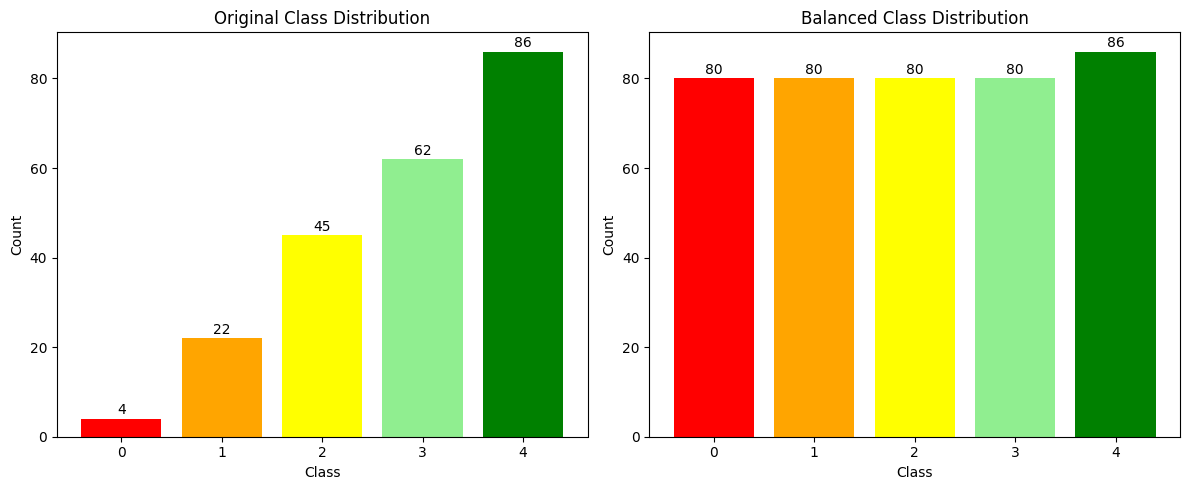


💾 Class balance comparison saved to: /content/drive/MyDrive/task_1/whisper_only_balanced_v1/class_balance_comparison.png
💾 Configuration summary saved to: /content/drive/MyDrive/task_1/whisper_only_balanced_v1/config_summary.json

🎉 WHISPER-ONLY BALANCED DATASET CREATION COMPLETED!
✅ Pure Whisper features extracted
✅ Dataset balanced using advanced techniques
✅ All files saved to output directory
✅ Ready for any classifier of your choice!


In [31]:
# ============================================================================
# CELL 13: FINAL SUMMARY AND FEATURE ANALYSIS
# ============================================================================
print("\n" + "="*80)
print("[10/9] FEATURE ANALYSIS AND SUMMARY")
print("="*80)

# Feature statistics
print("📊 FEATURE STATISTICS:")
print(f"Feature dimension: {X_train_final.shape[1]}")
print(f"Mean features per dimension: {np.mean(X_train_final, axis=0)[:5]}...")  # First 5
print(f"Std features per dimension: {np.std(X_train_final, axis=0)[:5]}...")    # First 5
print(f"Feature range: [{X_train_final.min():.4f}, {X_train_final.max():.4f}]")

# Class distribution visualization
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
unique, counts = np.unique(y_train, return_counts=True)
plt.bar(unique, counts, color=['red', 'orange', 'yellow', 'lightgreen', 'green'])
plt.title('Original Class Distribution')
plt.xlabel('Class')
plt.ylabel('Count')
for i, (cls, count) in enumerate(zip(unique, counts)):
    plt.text(cls, count + 1, str(count), ha='center')

plt.subplot(1, 2, 2)
unique_bal, counts_bal = np.unique(y_train_final, return_counts=True)
plt.bar(unique_bal, counts_bal, color=['red', 'orange', 'yellow', 'lightgreen', 'green'])
plt.title('Balanced Class Distribution')
plt.xlabel('Class')
plt.ylabel('Count')
for i, (cls, count) in enumerate(zip(unique_bal, counts_bal)):
    plt.text(cls, count + 1, str(count), ha='center')

plt.tight_layout()
plt.savefig(os.path.join(config.OUTPUT_PATH, 'class_balance_comparison.png'), dpi=300, bbox_inches='tight')
plt.show()

print(f"\n💾 Class balance comparison saved to: {os.path.join(config.OUTPUT_PATH, 'class_balance_comparison.png')}")

# Save final configuration
config_summary = {
    'whisper_model': config.WHISPER_MODEL,
    'feature_dimension': int(X_train_final.shape[1]),
    'training_samples_original': int(X_train.shape[0]),
    'training_samples_balanced': int(X_train_final.shape[0]),
    'validation_samples': int(X_val.shape[0]),
    'balancing_strategy': config.BALANCING_STRATEGY,
    'target_min_samples': config.TARGET_MIN_SAMPLES,
    'multi_layer_extraction': config.USE_MULTI_LAYER,
    'multi_pooling': config.USE_MULTI_POOLING,
    'available_audio_types': config.AVAILABLE_AUDIO_TYPES,
    'timestamp': datetime.now().isoformat()
}

with open(os.path.join(config.OUTPUT_PATH, 'config_summary.json'), 'w') as f:
    json.dump(config_summary, f, indent=2)

print(f"💾 Configuration summary saved to: {os.path.join(config.OUTPUT_PATH, 'config_summary.json')}")

print("\n" + "="*80)
print("🎉 WHISPER-ONLY BALANCED DATASET CREATION COMPLETED!")
print("="*80)
print("✅ Pure Whisper features extracted")
print("✅ Dataset balanced using advanced techniques")
print("✅ All files saved to output directory")
print("✅ Ready for any classifier of your choice!")
print("="*80)


[15/9] OVERALL PERFORMANCE FOR WHISPER-ONLY BALANCED DATASET
📊 Dataset loaded:
Training: (406, 8704)
Validation: (53, 8704)

🎯 OVERALL PERFORMANCE METRICS:
Overall Accuracy:  0.5849
Overall F1-Score:  0.5864

🎯 TARGET ACHIEVEMENT:
Target F1-Score: 0.75
Achieved F1-Score: 0.5864
❌ Target not met. Need +0.1636 to reach target

📋 DETAILED CLASSIFICATION REPORT:
                     precision    recall  f1-score   support

  Severe Dysarthria     0.0000    0.0000    0.0000         2
Moderate Dysarthria     0.3000    0.7500    0.4286         4
    Mild Dysarthria     0.7500    0.5000    0.6000        12
No Dysarthria (ALS)     0.5000    0.5714    0.5333        14
            Healthy     0.7368    0.6667    0.7000        21

           accuracy                         0.5849        53
          macro avg     0.4574    0.4976    0.4524        53
       weighted avg     0.6165    0.5849    0.5864        53


🎯 PER-CLASS F1 SCORES:
   Severe Dysarthria        : 0.0000
   Moderate Dysarthria   

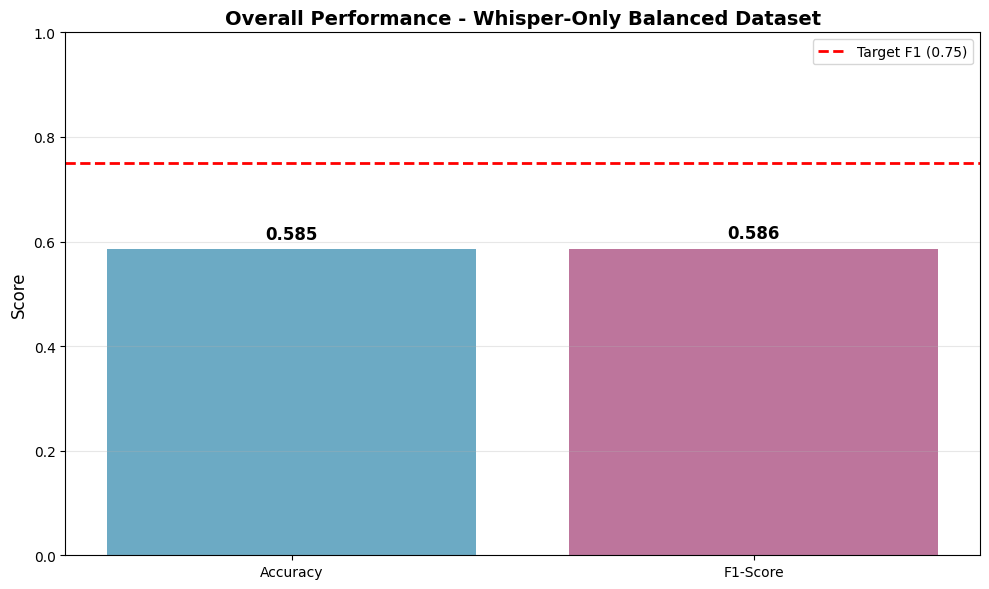

💾 Overall performance plot saved!


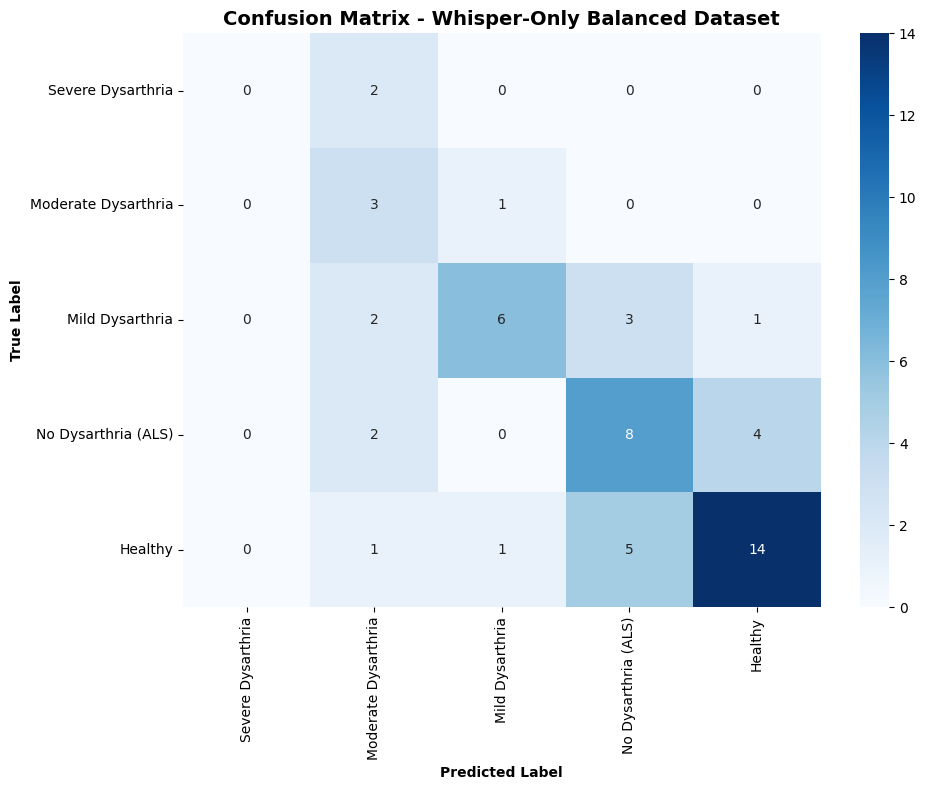

💾 Confusion matrix saved!

💾 Overall performance results saved to: /content/drive/MyDrive/task_1/whisper_only_balanced_v1/overall_performance.json

🎉 OVERALL PERFORMANCE CALCULATION COMPLETE!
📊 Overall Accuracy:  0.5849
📊 Overall F1-Score:  0.5864
🎯 Target F1-Score:   0.75
✅ Target Achieved:   False


In [34]:
# ============================================================================
# CELL 18: OVERALL ACCURACY AND F1 SCORE CALCULATION
# ============================================================================
print("\n" + "="*80)
print("[15/9] OVERALL PERFORMANCE FOR WHISPER-ONLY BALANCED DATASET")
print("="*80)

# Load the balanced dataset
X_train_balanced = np.load(os.path.join(config.OUTPUT_PATH, 'X_train_balanced.npy'))
y_train_balanced = np.load(os.path.join(config.OUTPUT_PATH, 'y_train_balanced.npy'))
X_val = np.load(os.path.join(config.OUTPUT_PATH, 'X_val.npy'))
y_val = np.load(os.path.join(config.OUTPUT_PATH, 'y_val.npy'))

print("📊 Dataset loaded:")
print(f"Training: {X_train_balanced.shape}")
print(f"Validation: {X_val.shape}")

# Use a simple classifier to get overall performance
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, f1_score, classification_report

# Train a classifier on the balanced dataset
classifier = RandomForestClassifier(n_estimators=100, random_state=42)
classifier.fit(X_train_balanced, y_train_balanced)

# Predict on validation set
y_pred = classifier.predict(X_val)

# Calculate overall metrics
overall_accuracy = accuracy_score(y_val, y_pred)
overall_f1 = f1_score(y_val, y_pred, average='weighted')

print("\n🎯 OVERALL PERFORMANCE METRICS:")
print("=" * 50)
print(f"Overall Accuracy:  {overall_accuracy:.4f}")
print(f"Overall F1-Score:  {overall_f1:.4f}")

# Check target achievement
target_f1 = 0.75
target_achieved = overall_f1 >= target_f1

print(f"\n🎯 TARGET ACHIEVEMENT:")
print("=" * 50)
print(f"Target F1-Score: {target_f1}")
print(f"Achieved F1-Score: {overall_f1:.4f}")
if target_achieved:
    print(f"✅ SUCCESS: Target F1-score ACHIEVED! (+{overall_f1 - target_f1:.4f})")
else:
    print(f"❌ Target not met. Need +{target_f1 - overall_f1:.4f} to reach target")

# Detailed classification report
print(f"\n📋 DETAILED CLASSIFICATION REPORT:")
print("=" * 60)
print(classification_report(y_val, y_pred,
                           target_names=[config.CLASS_NAMES[i] for i in range(5)],
                           digits=4))

# Per-class performance
per_class_f1 = f1_score(y_val, y_pred, average=None)
print(f"\n🎯 PER-CLASS F1 SCORES:")
for i, f1 in enumerate(per_class_f1):
    print(f"   {config.CLASS_NAMES[i]:25s}: {f1:.4f}")

# Create performance summary visualization
plt.figure(figsize=(10, 6))

# Plot overall metrics
metrics = ['Accuracy', 'F1-Score']
scores = [overall_accuracy, overall_f1]
colors = ['#2E86AB', '#A23B72']

plt.bar(metrics, scores, color=colors, alpha=0.7)
plt.axhline(y=target_f1, color='red', linestyle='--', linewidth=2, label=f'Target F1 ({target_f1})')
plt.ylim(0, 1.0)
plt.ylabel('Score', fontsize=12)
plt.title('Overall Performance - Whisper-Only Balanced Dataset', fontsize=14, fontweight='bold')
plt.grid(axis='y', alpha=0.3)
plt.legend()

# Add value labels on bars
for i, v in enumerate(scores):
    plt.text(i, v + 0.02, f'{v:.3f}', ha='center', fontweight='bold', fontsize=12)

plt.tight_layout()
plt.savefig(os.path.join(config.OUTPUT_PATH, 'overall_performance.png'), dpi=300, bbox_inches='tight')
plt.show()

print(f"💾 Overall performance plot saved!")

# Confusion Matrix
plt.figure(figsize=(10, 8))
cm = confusion_matrix(y_val, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=[config.CLASS_NAMES[i] for i in range(5)],
            yticklabels=[config.CLASS_NAMES[i] for i in range(5)])
plt.title('Confusion Matrix - Whisper-Only Balanced Dataset', fontsize=14, fontweight='bold')
plt.xlabel('Predicted Label', fontweight='bold')
plt.ylabel('True Label', fontweight='bold')
plt.tight_layout()
plt.savefig(os.path.join(config.OUTPUT_PATH, 'overall_confusion_matrix.png'), dpi=300, bbox_inches='tight')
plt.show()

print(f"💾 Confusion matrix saved!")

# Save overall performance results
overall_results = {
    'overall_accuracy': float(overall_accuracy),
    'overall_f1_score': float(overall_f1),
    'target_f1_score': float(target_f1),
    'target_achieved': bool(target_achieved),
    'dataset_info': {
        'training_samples': int(X_train_balanced.shape[0]),
        'validation_samples': int(X_val.shape[0]),
        'feature_dimension': int(X_train_balanced.shape[1]),
        'balancing_strategy': config.BALANCING_STRATEGY
    },
    'per_class_f1': {
        config.CLASS_NAMES[i]: float(f1) for i, f1 in enumerate(per_class_f1)
    },
    'evaluation_timestamp': datetime.now().isoformat()
}

with open(os.path.join(config.OUTPUT_PATH, 'overall_performance.json'), 'w') as f:
    json.dump(overall_results, f, indent=2)

print(f"\n💾 Overall performance results saved to: {os.path.join(config.OUTPUT_PATH, 'overall_performance.json')}")

print("\n" + "="*80)
print("🎉 OVERALL PERFORMANCE CALCULATION COMPLETE!")
print("="*80)
print(f"📊 Overall Accuracy:  {overall_accuracy:.4f}")
print(f"📊 Overall F1-Score:  {overall_f1:.4f}")
print(f"🎯 Target F1-Score:   {target_f1}")
print(f"✅ Target Achieved:   {target_achieved}")
print("="*80)